In [349]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [350]:
#closed form
#check for rank, then check for full rank, check for low rank d >n, 
#inverse is a costly func check how big the data size is with if statement for size and if it is bigger then dont do closed form

#gradient descent
#inout are x,y, e, alpha, max iteration, 
#losdd func, cost func, gradient of J(teta)

In [433]:
class LinearRegression:
    
    def __init__(self, X, y, max_iteration, epsilon, Learning_rate, gd, sgd, alpha=0.01, regularization=None) -> None:
        # Initialization of the LinearRegression class with parameters
        self.X = X
        self.y = y
        self.alpha = alpha
        self.max_iteration = max_iteration
        self.epsilon = epsilon
        self.Learning_rate = Learning_rate
        self.gd = gd
        self.sgd = sgd
        self.regularization = regularization 
        self.error_sequence = []  # To store error values during training

    def data_split(self):
        # Splitting data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3)
        return X_train, X_test, y_train, y_test
        
    
    def add_X0(self, X):
        # Adding a column of ones to the input matrix
        return np.column_stack([np.ones(X.shape[0]), X])
    
    def train_scaling(self, X):
        # Scaling the training data and adding a column of ones
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X = (X - mean) / std
        X = self.add_X0(X) #scaled the training data using the Z score normalization
        return X, mean, std
    
    def test_scaling(self, X, mean, std):
        # Scaling the test data using mean and std from training data
        X = (X - mean) / std
        X = self.add_X0(X)
        return X
    
    def rank(self, X):
        # Calculating the rank of a matrix using Singular Value Decomposition (SVD)
        v, s, u = np.linalg.svd(X)
        rank = np.sum(s > 0.00001)
        return rank
    
    def full_rank(self, X):
        # Checking if the matrix is full rank
        rank = self.rank(X)
        self.fullRank = rank == min(X.shape)
    
    def low_rank(self, X):
        # Checking if the matrix is low rank
        self.lowRank = X.shape[0] < X.shape[1]
        if self.lowRank:
            print("It's low rank")
    
    def closed_form_solution(self, X, y):
        # Computing the closed-form solution for linear regression
        if self.regularization:
            reg_term = self.alpha * np.eye(X.shape[1])
            self.w = np.linalg.inv(X.T.dot(X) + reg_term).dot(X.T).dot(y)
        else:
            self.w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        print("closed form solution")
        
    def predict(self, X):
        # Making predictions using the learned weights
        return X.dot(self.w)
    
    def sse(self, X, y):
        # Calculating the Sum of Squared Errors (SSE)
        y_hat = self.predict(X)
        return ((y_hat - y) ** 2).sum()
     
    def rmse(self, X, y):
        # Calculating the root mean squared errors (RMSE)
        sse = self.sse(X,y)
        rmse = np.sqrt(sse / X.shape[0])
        return rmse
    
    def cost_function(self, X, y):
        # Calculating the cost function with optional regularization term
        loss = self.sse(X, y)
        if self.regularization:
            reg_term = (self.alpha / 2) * np.sum(self.w[1:]**2)
            loss += reg_term
        return loss / 2
    
    def cost_derivative(self, X, y):
        # Calculating the derivative of the cost function with respect to weights
        y_hat = self.predict(X)
        if self.regularization:
            reg_derivative = self.alpha * np.concatenate(([0], self.w[1:]))
            return X.T.dot(y_hat - y) + reg_derivative
        else:
            return X.T.dot(y_hat - y)
    
    def gradient_descent(self, X, y):
        # Implementing gradient descent optimization algorithm
        errors = []
        prev_error = float("inf")
        for t in tqdm(range(self.max_iteration), colour='blue'):
            if self.regularization:
                self.w = self.w - self.Learning_rate * (self.cost_derivative(X,y) + self.alpha*self.w)
            else:
                self.w = self.w - self.Learning_rate * self.cost_derivative(X, y)
            loss = self.rmse(X, y)
            errors.append(loss)
            
            if abs(loss - prev_error) < self.epsilon:
                print("Model stopped learning")
                break
            prev_error = loss
        
        self.plot_rmse(errors)
    
    def stochastic_gradient_descent(self, X, y, batch_size=100):
        # Implementing stochastic gradient descent optimization algorithm
        errors = []
        prev_error = float("inf")
        for t in tqdm(range(self.max_iteration), colour='blue'):
            indices = np.random.randint(0, X.shape[0], batch_size)
            X_batch, y_batch = X[indices], y[indices]
            if self.regularization:
                self.w = self.w - self.Learning_rate * (self.cost_derivative(X_batch ,y_batch) + self.alpha*self.w)
            else:
                self.w = self.w - self.Learning_rate * self.cost_derivative(X_batch, y_batch)
            loss = self.rmse(X_batch, y_batch)
            errors.append(loss)
            
            if abs(loss - prev_error) < self.epsilon:
                print("Model stopped learning")
                break
            prev_error = loss
        
        self.plot_rmse(errors)
    
    def fit(self):
        # Training the linear regression model
        X_train, X_test, y_train , y_test = self.data_split()
        
        X_train, mean, std = self.train_scaling(X_train)
        X_test = self.test_scaling(X_test, mean, std)
        
        self.full_rank(X_train)
        self.low_rank(X_train)
        
        if self.fullRank and not self.lowRank and X_train.shape[1] < 1000 and not self.gd and not self.sgd:
            self.closed_form_solution(X_train, y_train) 
            print (self.w)
        elif self.gd:
            self.w = np.zeros(X_train.shape[1]) #initializing all the weights of gradient descent to zero
            self.gradient_descent(X_train, y_train)
            print("Gradient descent")
            print(self.w)
        elif self.sgd:
            self.w = np.ones(X_train.shape[1])
            self.stochastic_gradient_descent(X_train, y_train)
            print ("Stochastic gradient descent")
            print(self.w)
        print(f"SSE test:{lr.sse(X_test, y_test)}")
        print(f"RMSE test:{lr.rmse(X_test, y_test)}")
        print(f"SSE train:{lr.sse(X_train, y_train)}")
        print(f"RMSE train:{lr.rmse(X_train, y_train)}")
    
    def plot_rmse(self, error_sequence):
        # Plotting the RMSE during training
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='iterations', ylabel='RMSE',
               title='RMSE Trend')
        ax.grid()

        plt.show()


In [434]:
df = pd.read_csv('housing.csv',header=None) #reading the housing data

In [435]:
X = df.values[:,:-1] #features
y = df.values[:,-1] #y

In [436]:
#For the housing dataset we are doing closed form solution without regularization
lr = LinearRegression(X,y, Learning_rate = 0.0004, 
                      max_iteration=50000, sgd = False, gd=False, epsilon = 0.005, regularization = False)

In [437]:
lr.fit()

closed form solution
[22.54180791 -0.93115585  0.85955098 -0.28872741  0.72024417 -2.30943744
  2.33987598  0.27170105 -3.11767365  3.47413819 -2.18306755 -2.20633108
  0.94788046 -4.27446361]
SSE test:2663.129789761303
RMSE test:4.185760471182487
SSE train:8584.062063715854
RMSE train:4.924303289994707


In [438]:
#For the housing dataset we are doing closed form solution with regularization
lr = LinearRegression(X,y, Learning_rate = 0.0004, 
                      max_iteration=50000, sgd = False, gd=False, epsilon = 0.005, regularization = True)

In [439]:
lr.fit()

closed form solution
[22.5431485  -0.43609336  1.13763895 -0.15901088  0.80039659 -1.3250509
  3.23905316 -0.30882804 -2.91463391  2.3469363  -2.05148791 -1.71731207
  0.98551543 -3.61756319]
SSE test:4356.90045929794
RMSE test:5.353860178522657
SSE train:6950.295304990343
RMSE train:4.430982120982875


In [440]:
#For the housing dataset we are doing gradient descent without regularization
lr = LinearRegression(X,y, Learning_rate = 0.0004, 
                      max_iteration=50000, sgd = False, gd=True, epsilon = 0.005, regularization = False)

  0%|                                     | 34/50000 [00:00<00:01, 25970.92it/s]

Model stopped learning


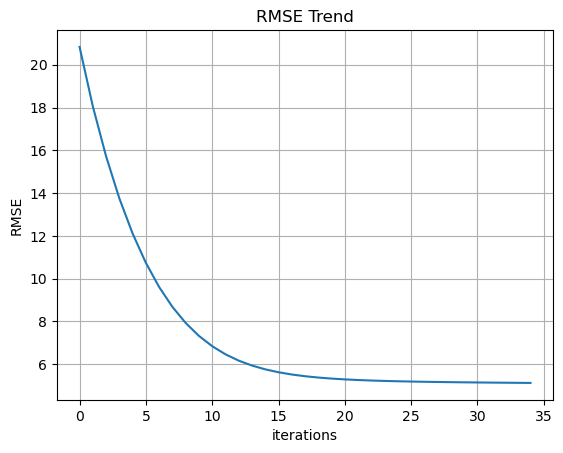

Gradient descent
[22.64385734 -0.65215917  0.70141957 -0.45659564  0.76197476 -1.4702128
  3.18792013  0.18771444 -2.33761426  1.32894445 -0.37818015 -2.074641
  0.8805308  -3.86567807]
SSE test:2090.2327701481677
RMSE test:3.708305729380162
SSE train:9302.70628944757
RMSE train:5.126288260147207


In [441]:
lr.fit()

In [442]:
#For the housing dataset we are doing gradient descent with regularization
lr = LinearRegression(X,y, Learning_rate = 0.0004, 
                      max_iteration=50000, sgd = False, gd=True, epsilon = 0.005, regularization = True)

  0%|                                     | 30/50000 [00:00<00:02, 18428.40it/s]

Model stopped learning


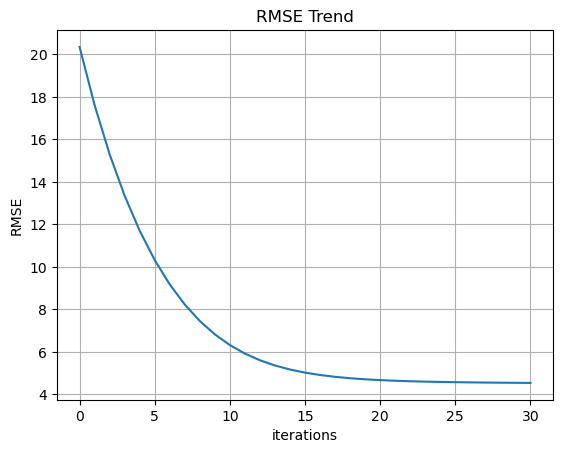

Gradient descent
[22.3162846  -0.06675915  0.4998605  -0.61306147  0.65104783 -0.83976068
  2.9951112   0.06223457 -1.92025506  0.82851559 -0.65394846 -1.76279489
  1.16244892 -3.46766459]
SSE test:4484.107097905973
RMSE test:5.43145510811667
SSE train:7294.558351066875
RMSE train:4.5393939063394875


In [443]:
lr.fit()

In [444]:
#For the housing dataset we are doing stochastic gradient descent without regularization
lr = LinearRegression(X,y, Learning_rate = 0.0004, 
                      max_iteration=50000, sgd = True, gd=False, epsilon = 0.005, regularization = False)

  0%|                                      | 22/50000 [00:00<00:05, 9589.97it/s]

Model stopped learning


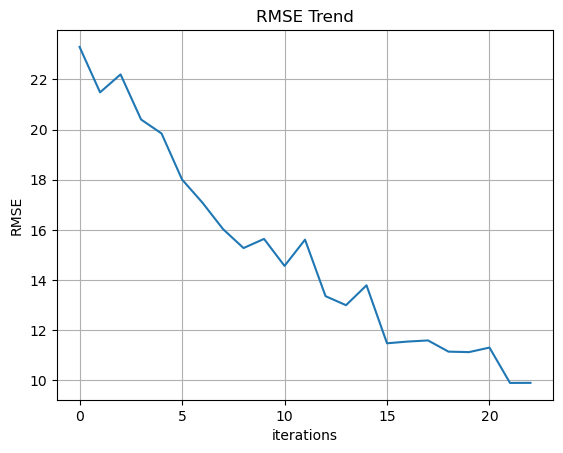

Stochastic gradient descent
[14.1850789  -0.35572139  0.76894646 -0.22322031  0.66384028  0.05807045
  3.30885814  0.40062735  0.38652816 -0.04139455 -0.56841004 -1.1376152
  1.50550216 -1.67245432]
SSE test:15415.140913047882
RMSE test:10.07052137397742
SSE train:34557.394300692366
RMSE train:9.880271145649818


In [445]:
lr.fit()

In [446]:
#For the housing dataset we are doing stochastic gradient descent with regularization
lr = LinearRegression(X,y, Learning_rate = 0.0004, 
                      max_iteration=50000, sgd = True, gd=False, epsilon = 0.005, regularization = True)

  2%|▋                                   | 877/50000 [00:00<00:02, 24229.84it/s]

Model stopped learning


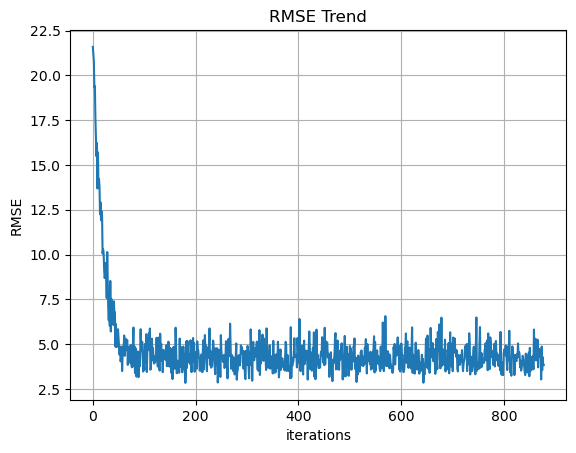

Stochastic gradient descent
[22.25694325 -1.01366187  1.49925297 -0.19333127  0.79932138 -1.68113885
  3.01686247 -0.61283125 -3.13695516  2.23386638 -2.03714104 -1.83472012
  1.14962758 -2.86433683]
SSE test:4798.579511566788
RMSE test:5.618683302143083
SSE train:6779.250241430638
RMSE train:4.376119789359177


In [447]:
lr.fit()

In [448]:
df = pd.read_csv('yachtData.csv',header=None)

In [449]:
X = df.values[:,:-1]
y = df.values[:,-1]

In [450]:
#For the yacht dataset we are doing closed form solution without regularization
lr = LinearRegression(X,y, Learning_rate = 0.001,epsilon = 0.001, 
                      max_iteration=50000, sgd = False, gd=False, regularization = False)

In [451]:
lr.fit()

closed form solution
[ 9.54981395  0.93460114 -0.8555114  -1.19367752  0.88882009  0.92745099
 11.50227546]
SSE test:9655.754968189749
RMSE test:10.189471146168453
SSE train:14820.925300037026
RMSE train:8.302682474913874


In [452]:
#For the yacht dataset we are doing closed form solution with regularization
lr = LinearRegression(X,y, Learning_rate = 0.001,epsilon = 0.001, 
                      max_iteration=50000, sgd = False, gd=False, regularization = True)

In [453]:
lr.fit()

closed form solution
[10.49858146 -0.28033024  0.09798508  0.51338163 -1.34840515 -0.97232961
 12.48636116]
SSE test:7811.459158127541
RMSE test:9.164834122666655
SSE train:16654.653285864766
RMSE train:8.801335333640287


In [454]:
#For the yacht dataset we are doing gradient descent without regularization
lr = LinearRegression(X,y, Learning_rate = 0.001,epsilon = 0.001, 
                      max_iteration=50000, sgd = False, gd=True, regularization = False)

  0%|                                     | 18/50000 [00:00<00:01, 32499.99it/s]

Model stopped learning


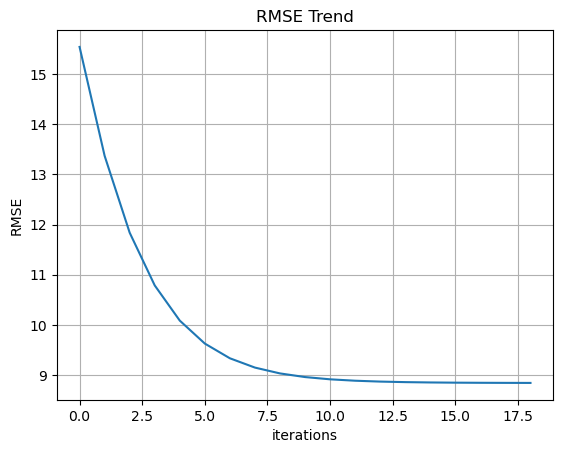

Gradient descent
[10.36183515  0.05131004 -0.06892043 -0.45318905 -0.29289647 -0.11301649
 12.33330549]
SSE test:7523.661924972354
RMSE test:8.994419969686794
SSE train:16807.24212949801
RMSE train:8.841562034333498


In [455]:
lr.fit()

In [456]:
#For the yacht dataset we are doing gradient descent with regularization
lr = LinearRegression(X,y, Learning_rate = 0.001,epsilon = 0.001, 
                      max_iteration=50000, sgd = False, gd=True, regularization = True)

  0%|                                     | 18/50000 [00:00<00:02, 18499.75it/s]

Model stopped learning


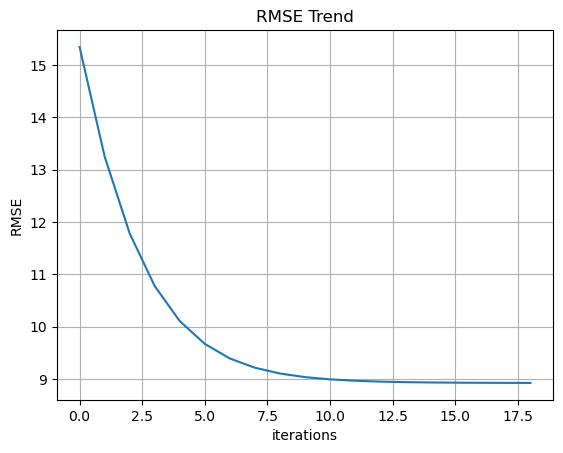

Gradient descent
[10.01113894  0.189005   -0.08007424 -0.05076195  0.07079694 -0.1816886
 12.13962325]
SSE test:7121.096773374273
RMSE test:8.750481875133232
SSE train:17134.357425633072
RMSE train:8.927188006344378


In [457]:
lr.fit()

In [458]:
#For the yacht dataset we are doing stochastic gradient descent without regularization
lr = LinearRegression(X,y, Learning_rate = 0.001,epsilon = 0.001, 
                      max_iteration=50000, sgd = True, gd=False, regularization = False)

  1%|▏                                   | 269/50000 [00:00<00:04, 11519.87it/s]

Model stopped learning


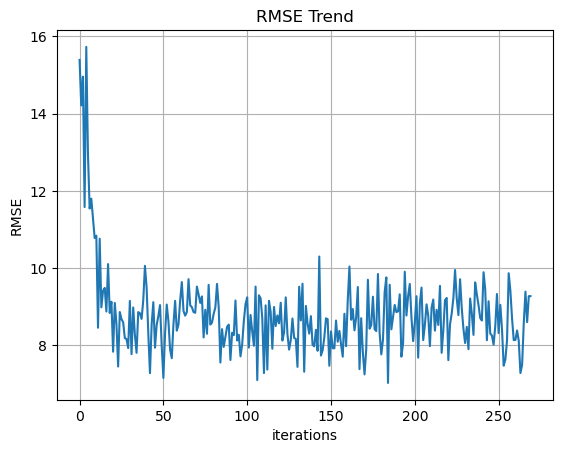

Stochastic gradient descent
[10.55024077  0.80039859 -0.65067268 -0.20169587 -0.69877454 -0.26162116
 12.6757542 ]
SSE test:8158.242821046769
RMSE test:9.366057926711983
SSE train:16339.504813373376
RMSE train:8.717665788867327


In [459]:
lr.fit()

In [460]:
#For the yacht dataset we are doing stochastic gradient descent with regularization
lr = LinearRegression(X,y, Learning_rate = 0.001,epsilon = 0.001, 
                      max_iteration=50000, sgd = True, gd=False, regularization = True)

  5%|█▊                                 | 2568/50000 [00:00<00:02, 21676.77it/s]


Model stopped learning


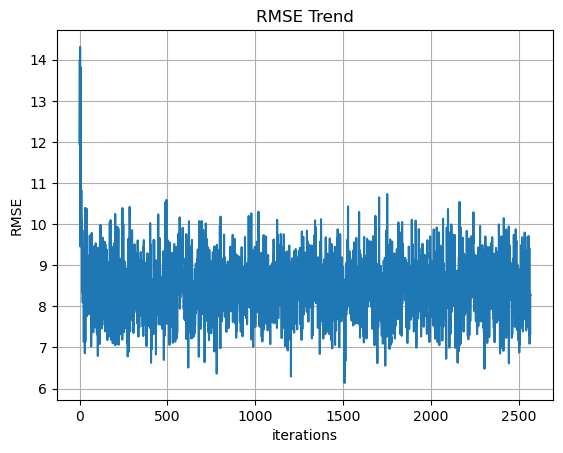

Stochastic gradient descent
[ 9.71391076  0.94686114  0.89323014  4.40565933 -4.44510166 -4.17391556
 11.91394285]
SSE test:8755.153941191737
RMSE test:9.702651195826228
SSE train:15783.456625830007
RMSE train:8.568046811651486


In [461]:
lr.fit()

In [462]:
df = pd.read_csv('concreteData.csv',header=None)

In [463]:
X = df.values[:,:-1]
y = df.values[:,-1]

In [464]:
#For the concrete dataset we are doing closed form solution without regularization
lr = LinearRegression(X,y, Learning_rate = 0.0007,epsilon = 0.0001, 
                      max_iteration=50000, sgd = False, gd=False, regularization = False)

In [465]:
lr.fit()

closed form solution
[35.90730929 13.50756461  9.74001894  6.18924555 -2.42827487  1.83390832
  2.12954851  2.0414894   7.41562605]
SSE test:30412.016989406344
RMSE test:9.920724114499283
SSE train:80611.72348873859
RMSE train:10.573809234705989


In [466]:
#For the concrete dataset we are doing closed form solution with regularization
lr = LinearRegression(X,y, Learning_rate = 0.0007,epsilon = 0.0001, 
                      max_iteration=50000, sgd = False, gd=False, regularization = True)

In [467]:
lr.fit()

closed form solution
[35.38727618 11.95138626  7.9672363   4.78796627 -3.86219832  1.65430391
  0.91023634  1.01557441  6.72768533]
SSE test:32920.95671254662
RMSE test:10.321836706012538
SSE train:78257.03470314412
RMSE train:10.41823289069186


In [468]:
#For the concrete dataset we are doing gradient descent without regularization
lr = LinearRegression(X,y, Learning_rate = 0.0007,epsilon = 0.0001, 
                      max_iteration=50000, sgd = False, gd=True, regularization = False)

  0%|                                    | 148/50000 [00:00<00:04, 12299.52it/s]

Model stopped learning


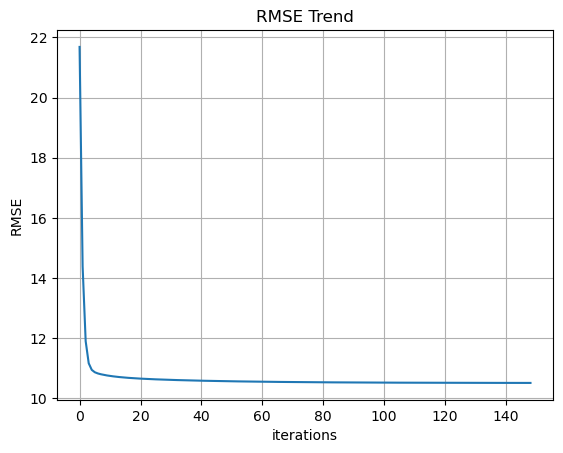

Gradient descent
[36.06832178 12.17080558  8.96959169  5.67523634 -2.66218378  2.10806851
  1.77735873  1.98746613  7.39635643]
SSE test:31054.43036091907
RMSE test:10.024957587481657
SSE train:79676.60693893618
RMSE train:10.512300894457498


In [469]:
lr.fit()

In [470]:
#For the concrete dataset we are doing gradient descent with regularization
lr = LinearRegression(X,y, Learning_rate = 0.0007,epsilon = 0.0001, 
                      max_iteration=50000, sgd = False, gd=True, regularization = True)

  0%|                                     | 139/50000 [00:00<00:07, 6641.17it/s]

Model stopped learning


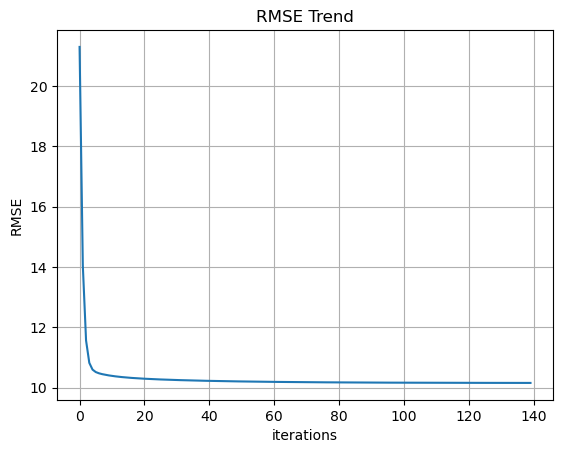

Gradient descent
[35.35809489 12.29241514  8.84854644  5.1965268  -3.18589292  2.18799798
  1.72790471  1.63742401  7.30307024]
SSE test:36316.35917659757
RMSE test:10.841064084047552
SSE train:74408.42397785146
RMSE train:10.158823633248314


In [471]:
lr.fit()

In [472]:
#For the concrete dataset we are doing stochastic gradient descent without regularization
lr = LinearRegression(X,y, Learning_rate = 0.0007,epsilon = 0.0001, 
                      max_iteration=50000, sgd = True, gd=False, regularization = False)

  4%|█▎                                 | 1960/50000 [00:00<00:01, 30000.64it/s]

Model stopped learning


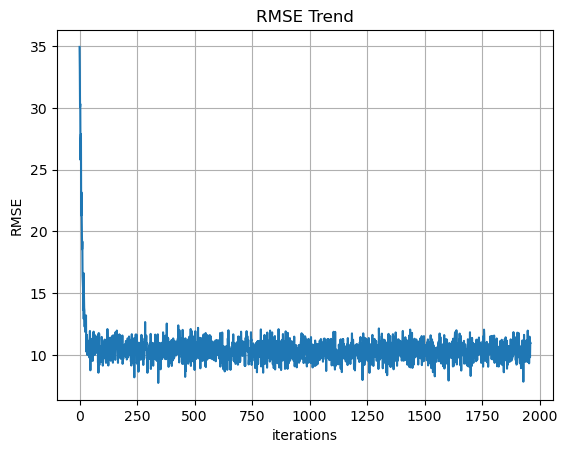

Stochastic gradient descent
[36.48088701 12.4163254   8.76776013  6.14499788 -3.33378825  1.16357064
  1.20259318  1.80426715  6.90231874]
SSE test:32222.799584946795
RMSE test:10.211802231029205
SSE train:78840.0040860262
RMSE train:10.456965777304625


In [473]:
lr.fit()

In [474]:
#For the concrete dataset we are doing stochastic gradient descent with regularization
lr = LinearRegression(X,y, Learning_rate = 0.0007,epsilon = 0.0001, 
                      max_iteration=50000, sgd = True, gd=False, regularization = True)

 15%|█████                              | 7309/50000 [00:00<00:01, 25476.58it/s]


Model stopped learning


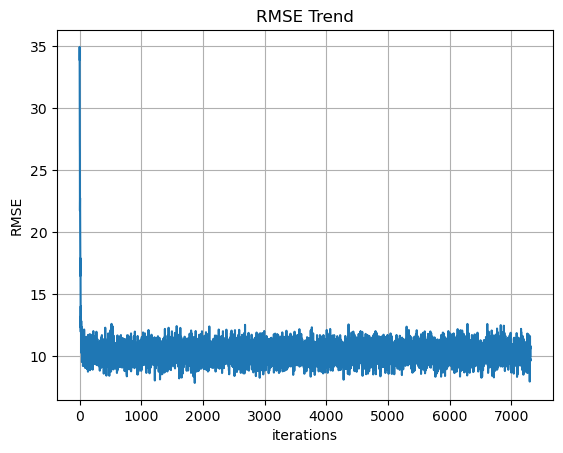

Stochastic gradient descent
[35.46803934 12.85670921  9.34423713  5.79604353 -3.42694425  1.11941945
  1.49969394  2.09010651  7.34668312]
SSE test:33069.36760484861
RMSE test:10.345076468322135
SSE train:77765.50187703811
RMSE train:10.385462866035411


In [475]:
lr.fit()

For the concrete data the CLOSED FORM SOLUTION WITHOUT REGULARIZATION gave the best performance with the least RMSE value of the test set of about 9.920724114499283
